In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from lungDataLoader import lung424

class UNET(nn.Module):

        def __init__(self):
            super(UNET, self).__init__()
            #conv block 1
            self.conv1_1 = nn.Conv2d(3, 32, 3, padding=1, stride=1, dilation=1)
            self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1, stride=1, dilation=1)
            #conv block 2
            self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1, stride=1, dilation=1)
            self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1, stride=1, dilation=1)
            #conv block 3
            self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1, stride=1, dilation=1)
            self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1, stride=1, dilation=1)
            #conv block 4
            self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1, stride=1, dilation=1)
            self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1, stride=1, dilation=1)
            #deepeast conv block
            self.conv5_1 = nn.Conv2d(256, 512, 3, padding=1, stride=1, dilation=1)
            self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1, stride=1, dilation=1)
            #reserver conv block0
            self.deconv5_1 = nn.Conv2d(512, 256, 1, padding=0, stride=1, dilation=1)
            self.deconv5_2 = nn.Conv2d(512, 256, 3, padding=1, stride=1, dilation=1)
            self.deconv5_3 = nn.Conv2d(256, 256, 3, padding=1, stride=1, dilation=1)
            #reverse conv block 1
            self.deconv4_1 = nn.Conv2d(256, 128, 1, padding=0, stride=1, dilation=1)
            self.deconv4_2 = nn.Conv2d(256, 128, 3, padding=1, stride=1, dilation=1)
            self.deconv4_3 = nn.Conv2d(128, 128, 3, padding=1, stride=1, dilation=1)
            #reverse conv block 2
            self.deconv3_1 = nn.Conv2d(128, 64, 1, padding=0, stride=1, dilation=1)
            self.deconv3_2 = nn.Conv2d(128, 64, 3, padding=1, stride=1, dilation=1)
            self.deconv3_3 = nn.Conv2d(64, 64, 3, padding=1, stride=1, dilation=1)
            #reverse conv block 3
            self.deconv2_1 = nn.Conv2d(64, 32, 1, padding=0, stride=1, dilation=1)
            self.deconv2_2 = nn.Conv2d(64, 32, 3, padding=1, stride=1, dilation=1)
            self.deconv2_3 = nn.Conv2d(32, 32, 3, padding=1, stride=1, dilation=1)
            self.deconv1_1 = nn.Conv2d(32, 2, 1, padding=0, stride=1, dilation=1)
            self.deconv1_2 = nn.Conv2d(2, 2, 3, padding=1, stride=1, dilation=1)
            self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        def forward(self, x):
            x1 = F.relu(self.conv1_2(F.relu(self.conv1_1(x)))) # 224x224, 32
            x2 = F.relu(self.conv2_2(F.relu(self.conv2_1(F.max_pool2d(x1, 2))))) # 112x112, 64
            x3 = F.relu(self.conv3_2(F.relu(self.conv3_1(F.max_pool2d(x2, 2))))) # 56x56, 128
            x4 = F.relu(self.conv4_2(F.relu(self.conv4_1(F.max_pool2d(x3, 2))))) # 28x28, 256
            x = F.relu(self.conv5_2(F.relu(self.conv5_1(F.max_pool2d(x4, 2))))) # 14x14, 512
            # 28x28, 256            
            x = F.relu(self.deconv5_3(F.relu(self.deconv5_2(torch.cat([x4, self.upsample(F.relu(self.deconv5_1(x)))], dim=1))))) 
            # 56x56, 128            
            x = F.relu(self.deconv4_3(F.relu(self.deconv4_2(torch.cat([x3, self.upsample(F.relu(self.deconv4_1(x)))], dim=1))))) 
            # 112x112, 64
            x = F.relu(self.deconv3_3(F.relu(self.deconv3_2(torch.cat([x2, self.upsample(F.relu(self.deconv3_1(x)))], dim=1))))) 
            # 224x224, 32
            x = F.relu(self.deconv2_3(F.relu(self.deconv2_2(torch.cat([x1, self.upsample(F.relu(self.deconv2_1(x)))], dim=1))))) 
            x = self.deconv1_2(self.deconv1_1(x)) # 224x224, 1
            return x

In [2]:
unet = UNET().cuda()
lungDataLoader = DataLoader(lung424, shuffle=True, batch_size=5)

lr = 0.001
momentum = 0.9
optimizer = optim.SGD(unet.parameters(), lr, momentum)
criterion = nn.CrossEntropyLoss()

In [3]:
## init the parameters of neural network
def initNetParams(net):  
    '''''Init net parameters.'''  
    for m in net.modules():  
        if isinstance(m, nn.Conv2d):  
            init.xavier_uniform(m.weight)  
            if m.bias:  
                init.constant(m.bias, 0)  
        elif isinstance(m, nn.BatchNorm2d):  
            init.constant(m.weight, 1)  
            init.constant(m.bias, 0)  
        elif isinstance(m, nn.Linear):  
            init.normal(m.weight, std=1e-3)  
            if m.bias:  
                init.constant(m.bias, 0)
                
initNetParams(unet)  

In [4]:
## training network
runing_loss = 0.0
for epoch in range(100):
    for i, data in enumerate(lungDataLoader):
        img, target = data
        print('Number {} batch with batch size {}'.format(i, img.size()))
        
        img, target = Variable(img.cuda()), Variable(target.cuda())
        
        optimizer.zero_grad()
        out = unet(img)
#       print(out.size(), target.size())
        target = torch.squeeze(target, dim=1)
        
        loss = criterion(out, target)
        loss.backward()
        
        optimizer.step()
        
        runing_loss += loss.data[0]
        print('[epoch : %d, batch : %5d] loss: %.3f' % 
            (epoch + 1, i + 1, runing_loss))
        runing_loss = 0.0

Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     1] loss: 0.688
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     2] loss: 0.686
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     3] loss: 0.683
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     4] loss: 0.684
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     5] loss: 0.679
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     6] loss: 0.674
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     7] loss: 0.668
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     8] loss: 0.661
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :     9] loss: 0.656
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :    10] loss: 0.649
Number 10 

Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 1, batch :    84] loss: 0.396
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 1, batch :    85] loss: 0.445
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     1] loss: 0.353
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     2] loss: 0.395
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     3] loss: 0.372
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     4] loss: 0.437
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     5] loss: 0.361
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     6] loss: 0.398
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     7] loss: 0.376
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :     8] loss: 0.375
Number 8

Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :    83] loss: 0.372
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 2, batch :    84] loss: 0.339
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 2, batch :    85] loss: 0.555
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     1] loss: 0.462
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     2] loss: 0.438
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     3] loss: 0.370
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     4] loss: 0.412
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     5] loss: 0.372
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     6] loss: 0.504
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :     7] loss: 0.407
Number 

Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :    82] loss: 0.345
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :    83] loss: 0.329
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 3, batch :    84] loss: 0.399
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 3, batch :    85] loss: 0.388
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :     1] loss: 0.376
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :     2] loss: 0.367
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :     3] loss: 0.430
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :     4] loss: 0.314
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :     5] loss: 0.329
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :     6] loss: 0.446
Number

Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :    81] loss: 0.383
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :    82] loss: 0.331
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :    83] loss: 0.355
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 4, batch :    84] loss: 0.477
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 4, batch :    85] loss: 0.494
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :     1] loss: 0.356
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :     2] loss: 0.341
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :     3] loss: 0.462
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :     4] loss: 0.359
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :     5] loss: 0.425
Numbe

[epoch : 5, batch :    80] loss: 0.412
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :    81] loss: 0.362
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :    82] loss: 0.357
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :    83] loss: 0.400
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 5, batch :    84] loss: 0.479
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 5, batch :    85] loss: 0.343
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :     1] loss: 0.435
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :     2] loss: 0.430
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :     3] loss: 0.413
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :     4] loss: 0.363
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoc

[epoch : 6, batch :    79] loss: 0.356
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :    80] loss: 0.373
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :    81] loss: 0.329
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :    82] loss: 0.323
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :    83] loss: 0.359
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 6, batch :    84] loss: 0.400
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 6, batch :    85] loss: 0.451
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :     1] loss: 0.324
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :     2] loss: 0.404
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :     3] loss: 0.425
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epo

[epoch : 7, batch :    78] loss: 0.411
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :    79] loss: 0.391
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :    80] loss: 0.352
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :    81] loss: 0.312
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :    82] loss: 0.358
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :    83] loss: 0.380
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 7, batch :    84] loss: 0.356
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 7, batch :    85] loss: 0.416
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :     1] loss: 0.424
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :     2] loss: 0.431
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[ep

[epoch : 8, batch :    77] loss: 0.311
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    78] loss: 0.341
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    79] loss: 0.386
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    80] loss: 0.339
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    81] loss: 0.364
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    82] loss: 0.364
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    83] loss: 0.343
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 8, batch :    84] loss: 0.318
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 8, batch :    85] loss: 0.440
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :     1] loss: 0.306
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[e

Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    77] loss: 0.426
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    78] loss: 0.350
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    79] loss: 0.336
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    80] loss: 0.317
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    81] loss: 0.421
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    82] loss: 0.426
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    83] loss: 0.309
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 9, batch :    84] loss: 0.348
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 9, batch :    85] loss: 0.379
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :     1] loss: 0.339


[epoch : 10, batch :    73] loss: 0.413
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    74] loss: 0.290
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    75] loss: 0.305
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    76] loss: 0.378
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    77] loss: 0.337
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    78] loss: 0.408
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    79] loss: 0.370
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    80] loss: 0.367
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    81] loss: 0.348
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 10, batch :    82] loss: 0.325
Number 82 batch with batch size torch.Size([5, 3, 2

Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    71] loss: 0.364
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    72] loss: 0.388
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    73] loss: 0.353
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    74] loss: 0.373
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    75] loss: 0.341
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    76] loss: 0.313
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    77] loss: 0.300
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    78] loss: 0.350
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    79] loss: 0.321
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 11, batch :    80] lo

Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    68] loss: 0.153
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    69] loss: 0.151
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    70] loss: 0.159
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    71] loss: 0.146
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    72] loss: 0.139
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    73] loss: 0.323
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    74] loss: 0.221
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    75] loss: 0.147
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    76] loss: 0.189
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 12, batch :    77] lo

Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    66] loss: 0.050
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    67] loss: 0.062
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    68] loss: 0.055
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    69] loss: 0.038
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    70] loss: 0.041
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    71] loss: 0.055
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    72] loss: 0.035
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    73] loss: 0.039
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    74] loss: 0.054
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 13, batch :    75] lo

[epoch : 14, batch :    65] loss: 0.037
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    66] loss: 0.041
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    67] loss: 0.032
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    68] loss: 0.026
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    69] loss: 0.040
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    70] loss: 0.054
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    71] loss: 0.046
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    72] loss: 0.032
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    73] loss: 0.060
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 14, batch :    74] loss: 0.027
Number 74 batch with batch size torch.Size([5, 3, 2

[epoch : 15, batch :    64] loss: 0.039
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    65] loss: 0.042
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    66] loss: 0.022
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    67] loss: 0.052
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    68] loss: 0.022
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    69] loss: 0.045
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    70] loss: 0.064
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    71] loss: 0.037
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    72] loss: 0.044
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 15, batch :    73] loss: 0.032
Number 73 batch with batch size torch.Size([5, 3, 2

[epoch : 16, batch :    63] loss: 0.040
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    64] loss: 0.025
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    65] loss: 0.038
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    66] loss: 0.042
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    67] loss: 0.023
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    68] loss: 0.028
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    69] loss: 0.026
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    70] loss: 0.033
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    71] loss: 0.026
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 16, batch :    72] loss: 0.046
Number 72 batch with batch size torch.Size([5, 3, 2

Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    63] loss: 0.026
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    64] loss: 0.052
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    65] loss: 0.036
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    66] loss: 0.034
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    67] loss: 0.042
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    68] loss: 0.030
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    69] loss: 0.024
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    70] loss: 0.032
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    71] loss: 0.036
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 17, batch :    72] lo

Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    62] loss: 0.022
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    63] loss: 0.024
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    64] loss: 0.031
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    65] loss: 0.039
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    66] loss: 0.021
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    67] loss: 0.032
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    68] loss: 0.022
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    69] loss: 0.020
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    70] loss: 0.030
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 18, batch :    71] lo

Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    61] loss: 0.025
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    62] loss: 0.032
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    63] loss: 0.021
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    64] loss: 0.020
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    65] loss: 0.046
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    66] loss: 0.033
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    67] loss: 0.024
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    68] loss: 0.028
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    69] loss: 0.020
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 19, batch :    70] lo

Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    60] loss: 0.037
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    61] loss: 0.031
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    62] loss: 0.041
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    63] loss: 0.029
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    64] loss: 0.038
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    65] loss: 0.025
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    66] loss: 0.023
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    67] loss: 0.045
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    68] loss: 0.052
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 20, batch :    69] lo

[epoch : 21, batch :    57] loss: 0.021
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    58] loss: 0.027
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    59] loss: 0.021
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    60] loss: 0.018
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    61] loss: 0.031
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    62] loss: 0.021
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    63] loss: 0.021
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    64] loss: 0.043
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    65] loss: 0.023
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 21, batch :    66] loss: 0.021
Number 66 batch with batch size torch.Size([5, 3, 2

Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    56] loss: 0.029
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    57] loss: 0.020
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    58] loss: 0.027
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    59] loss: 0.021
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    60] loss: 0.022
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    61] loss: 0.021
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    62] loss: 0.022
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    63] loss: 0.030
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    64] loss: 0.037
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 22, batch :    65] lo

Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    55] loss: 0.033
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    56] loss: 0.018
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    57] loss: 0.020
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    58] loss: 0.025
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    59] loss: 0.025
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    60] loss: 0.019
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    61] loss: 0.019
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    62] loss: 0.021
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    63] loss: 0.023
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 23, batch :    64] lo

Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    54] loss: 0.021
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    55] loss: 0.021
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    56] loss: 0.025
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    57] loss: 0.019
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    58] loss: 0.024
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    59] loss: 0.020
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    60] loss: 0.026
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    61] loss: 0.021
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    62] loss: 0.033
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 24, batch :    63] lo

[epoch : 25, batch :    52] loss: 0.018
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    53] loss: 0.023
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    54] loss: 0.026
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    55] loss: 0.019
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    56] loss: 0.027
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    57] loss: 0.025
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    58] loss: 0.038
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    59] loss: 0.020
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    60] loss: 0.025
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 25, batch :    61] loss: 0.022
Number 61 batch with batch size torch.Size([5, 3, 2

[epoch : 26, batch :    51] loss: 0.018
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    52] loss: 0.022
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    53] loss: 0.026
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    54] loss: 0.016
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    55] loss: 0.033
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    56] loss: 0.030
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    57] loss: 0.023
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    58] loss: 0.027
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    59] loss: 0.025
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 26, batch :    60] loss: 0.017
Number 60 batch with batch size torch.Size([5, 3, 2

Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    50] loss: 0.016
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    51] loss: 0.022
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    52] loss: 0.023
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    53] loss: 0.022
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    54] loss: 0.019
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    55] loss: 0.017
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    56] loss: 0.025
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    57] loss: 0.018
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    58] loss: 0.021
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 27, batch :    59] lo

[epoch : 28, batch :    48] loss: 0.023
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    49] loss: 0.033
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    50] loss: 0.018
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    51] loss: 0.028
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    52] loss: 0.021
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    53] loss: 0.017
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    54] loss: 0.020
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    55] loss: 0.020
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    56] loss: 0.018
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 28, batch :    57] loss: 0.020
Number 57 batch with batch size torch.Size([5, 3, 2

[epoch : 29, batch :    46] loss: 0.023
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    47] loss: 0.027
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    48] loss: 0.021
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    49] loss: 0.015
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    50] loss: 0.017
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    51] loss: 0.021
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    52] loss: 0.019
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    53] loss: 0.019
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    54] loss: 0.030
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 29, batch :    55] loss: 0.018
Number 55 batch with batch size torch.Size([5, 3, 2

[epoch : 30, batch :    45] loss: 0.019
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    46] loss: 0.022
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    47] loss: 0.021
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    48] loss: 0.017
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    49] loss: 0.030
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    50] loss: 0.022
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    51] loss: 0.022
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    52] loss: 0.026
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    53] loss: 0.020
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 30, batch :    54] loss: 0.021
Number 54 batch with batch size torch.Size([5, 3, 2

[epoch : 31, batch :    44] loss: 0.019
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    45] loss: 0.017
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    46] loss: 0.021
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    47] loss: 0.017
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    48] loss: 0.019
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    49] loss: 0.020
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    50] loss: 0.020
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    51] loss: 0.022
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    52] loss: 0.020
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 31, batch :    53] loss: 0.018
Number 53 batch with batch size torch.Size([5, 3, 2

[epoch : 32, batch :    43] loss: 0.026
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    44] loss: 0.020
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    45] loss: 0.018
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    46] loss: 0.021
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    47] loss: 0.027
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    48] loss: 0.017
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    49] loss: 0.034
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    50] loss: 0.023
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    51] loss: 0.019
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 32, batch :    52] loss: 0.017
Number 52 batch with batch size torch.Size([5, 3, 2

[epoch : 33, batch :    42] loss: 0.021
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    43] loss: 0.018
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    44] loss: 0.019
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    45] loss: 0.016
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    46] loss: 0.015
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    47] loss: 0.017
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    48] loss: 0.022
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    49] loss: 0.018
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    50] loss: 0.016
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 33, batch :    51] loss: 0.018
Number 51 batch with batch size torch.Size([5, 3, 2

Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    42] loss: 0.024
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    43] loss: 0.017
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    45] loss: 0.017
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    46] loss: 0.017
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    47] loss: 0.021
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    48] loss: 0.021
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    49] loss: 0.017
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    50] loss: 0.019
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 34, batch :    51] lo

Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    41] loss: 0.017
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    42] loss: 0.019
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    43] loss: 0.018
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    45] loss: 0.019
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    46] loss: 0.025
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    47] loss: 0.018
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    48] loss: 0.027
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    49] loss: 0.017
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 35, batch :    50] lo

Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    40] loss: 0.021
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    41] loss: 0.019
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    42] loss: 0.018
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    43] loss: 0.019
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    44] loss: 0.020
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    45] loss: 0.025
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    46] loss: 0.021
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    47] loss: 0.029
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    48] loss: 0.020
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 36, batch :    49] lo

[epoch : 37, batch :    38] loss: 0.025
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    39] loss: 0.017
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    40] loss: 0.015
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    41] loss: 0.018
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    42] loss: 0.019
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    43] loss: 0.021
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    44] loss: 0.018
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    45] loss: 0.029
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    46] loss: 0.023
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 37, batch :    47] loss: 0.018
Number 47 batch with batch size torch.Size([5, 3, 2

[epoch : 38, batch :    37] loss: 0.019
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    38] loss: 0.018
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    39] loss: 0.022
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    40] loss: 0.017
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    41] loss: 0.023
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    42] loss: 0.022
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    43] loss: 0.022
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    44] loss: 0.018
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    45] loss: 0.017
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 38, batch :    46] loss: 0.018
Number 46 batch with batch size torch.Size([5, 3, 2

[epoch : 39, batch :    36] loss: 0.018
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    37] loss: 0.020
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    38] loss: 0.023
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    39] loss: 0.017
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    40] loss: 0.024
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    41] loss: 0.017
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    42] loss: 0.018
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    43] loss: 0.015
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    44] loss: 0.018
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 39, batch :    45] loss: 0.017
Number 45 batch with batch size torch.Size([5, 3, 2

Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    35] loss: 0.019
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    36] loss: 0.020
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    37] loss: 0.021
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    38] loss: 0.019
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    39] loss: 0.017
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    40] loss: 0.019
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    41] loss: 0.016
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    42] loss: 0.020
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    43] loss: 0.016
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 40, batch :    44] lo

Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    34] loss: 0.016
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    35] loss: 0.020
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    36] loss: 0.022
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    37] loss: 0.020
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    38] loss: 0.030
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    39] loss: 0.021
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    40] loss: 0.016
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    41] loss: 0.023
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    42] loss: 0.020
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 41, batch :    43] lo

Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    32] loss: 0.023
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    33] loss: 0.018
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    34] loss: 0.022
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    35] loss: 0.020
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    36] loss: 0.017
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    37] loss: 0.022
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    38] loss: 0.020
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    39] loss: 0.026
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    40] loss: 0.017
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 42, batch :    41] lo

Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    30] loss: 0.016
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    31] loss: 0.017
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    32] loss: 0.018
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    33] loss: 0.019
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    34] loss: 0.019
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    35] loss: 0.020
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    36] loss: 0.015
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    37] loss: 0.024
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    38] loss: 0.017
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 43, batch :    39] lo

[epoch : 44, batch :    29] loss: 0.026
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    30] loss: 0.027
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    31] loss: 0.023
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    32] loss: 0.027
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    33] loss: 0.018
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    34] loss: 0.017
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    35] loss: 0.033
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    36] loss: 0.022
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    37] loss: 0.020
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 44, batch :    38] loss: 0.019
Number 38 batch with batch size torch.Size([5, 3, 2

[epoch : 45, batch :    28] loss: 0.015
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    29] loss: 0.021
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    30] loss: 0.020
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    31] loss: 0.022
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    32] loss: 0.017
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    33] loss: 0.016
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    34] loss: 0.020
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    35] loss: 0.024
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    36] loss: 0.018
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 45, batch :    37] loss: 0.023
Number 37 batch with batch size torch.Size([5, 3, 2

Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    28] loss: 0.020
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    29] loss: 0.027
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    30] loss: 0.017
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    31] loss: 0.021
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    32] loss: 0.026
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    33] loss: 0.017
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    34] loss: 0.023
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    35] loss: 0.021
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    36] loss: 0.019
Number 36 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 46, batch :    37] lo

Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    27] loss: 0.023
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    28] loss: 0.024
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    29] loss: 0.019
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    30] loss: 0.016
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    31] loss: 0.017
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    32] loss: 0.021
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    33] loss: 0.017
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    34] loss: 0.016
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    35] loss: 0.021
Number 35 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 47, batch :    36] lo

Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    26] loss: 0.014
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    27] loss: 0.019
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    28] loss: 0.023
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    29] loss: 0.020
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    30] loss: 0.020
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    31] loss: 0.020
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    32] loss: 0.022
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    33] loss: 0.018
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    34] loss: 0.021
Number 34 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 48, batch :    35] lo

Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    25] loss: 0.023
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    26] loss: 0.019
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    27] loss: 0.018
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    28] loss: 0.018
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    29] loss: 0.020
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    30] loss: 0.017
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    31] loss: 0.018
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    32] loss: 0.019
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    33] loss: 0.017
Number 33 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 49, batch :    34] lo

[epoch : 50, batch :    24] loss: 0.017
Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    25] loss: 0.017
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    26] loss: 0.016
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    27] loss: 0.016
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    28] loss: 0.021
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    29] loss: 0.021
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    30] loss: 0.019
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    31] loss: 0.022
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    32] loss: 0.023
Number 32 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 50, batch :    33] loss: 0.018
Number 33 batch with batch size torch.Size([5, 3, 2

[epoch : 51, batch :    23] loss: 0.023
Number 23 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    24] loss: 0.017
Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    25] loss: 0.016
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    26] loss: 0.023
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    27] loss: 0.020
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    28] loss: 0.016
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    29] loss: 0.020
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    30] loss: 0.025
Number 30 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    31] loss: 0.017
Number 31 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 51, batch :    32] loss: 0.017
Number 32 batch with batch size torch.Size([5, 3, 2

[epoch : 52, batch :    21] loss: 0.019
Number 21 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    22] loss: 0.017
Number 22 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    23] loss: 0.025
Number 23 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    24] loss: 0.014
Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    25] loss: 0.027
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    26] loss: 0.023
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    27] loss: 0.023
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    28] loss: 0.024
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    29] loss: 0.017
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 52, batch :    30] loss: 0.020
Number 30 batch with batch size torch.Size([5, 3, 2

Number 20 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    21] loss: 0.017
Number 21 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    22] loss: 0.021
Number 22 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    23] loss: 0.022
Number 23 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    24] loss: 0.018
Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    25] loss: 0.026
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    26] loss: 0.017
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    27] loss: 0.019
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    28] loss: 0.022
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    29] loss: 0.024
Number 29 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 53, batch :    30] lo

Number 19 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    20] loss: 0.021
Number 20 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    21] loss: 0.017
Number 21 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    22] loss: 0.018
Number 22 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    23] loss: 0.018
Number 23 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    24] loss: 0.024
Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    25] loss: 0.022
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    26] loss: 0.014
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    27] loss: 0.027
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    28] loss: 0.017
Number 28 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 54, batch :    29] lo

Number 18 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    19] loss: 0.018
Number 19 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    20] loss: 0.017
Number 20 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    21] loss: 0.020
Number 21 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    22] loss: 0.018
Number 22 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    23] loss: 0.014
Number 23 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    24] loss: 0.014
Number 24 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    25] loss: 0.023
Number 25 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    26] loss: 0.014
Number 26 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    27] loss: 0.015
Number 27 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 55, batch :    28] lo

[epoch : 56, batch :    15] loss: 0.020
Number 15 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    16] loss: 0.020
Number 16 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    17] loss: 0.021
Number 17 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    18] loss: 0.019
Number 18 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    19] loss: 0.016
Number 19 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    20] loss: 0.016
Number 20 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    21] loss: 0.016
Number 21 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    22] loss: 0.019
Number 22 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    23] loss: 0.014
Number 23 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 56, batch :    24] loss: 0.019
Number 24 batch with batch size torch.Size([5, 3, 2

[epoch : 57, batch :    12] loss: 0.016
Number 12 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    13] loss: 0.016
Number 13 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    14] loss: 0.020
Number 14 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    15] loss: 0.019
Number 15 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    16] loss: 0.016
Number 16 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    17] loss: 0.024
Number 17 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    18] loss: 0.017
Number 18 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    19] loss: 0.016
Number 19 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    20] loss: 0.023
Number 20 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 57, batch :    21] loss: 0.020
Number 21 batch with batch size torch.Size([5, 3, 2

Number 11 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    12] loss: 0.017
Number 12 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    13] loss: 0.019
Number 13 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    14] loss: 0.014
Number 14 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    15] loss: 0.016
Number 15 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    16] loss: 0.016
Number 16 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    17] loss: 0.016
Number 17 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    18] loss: 0.018
Number 18 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    19] loss: 0.016
Number 19 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    20] loss: 0.016
Number 20 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 58, batch :    21] lo

[epoch : 59, batch :     9] loss: 0.021
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    10] loss: 0.021
Number 10 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    11] loss: 0.023
Number 11 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    12] loss: 0.018
Number 12 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    13] loss: 0.019
Number 13 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    14] loss: 0.020
Number 14 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    15] loss: 0.022
Number 15 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    16] loss: 0.020
Number 16 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    17] loss: 0.016
Number 17 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 59, batch :    18] loss: 0.021
Number 18 batch with batch size torch.Size([5, 3, 22

Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :     7] loss: 0.020
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :     8] loss: 0.019
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :     9] loss: 0.019
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    10] loss: 0.018
Number 10 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    11] loss: 0.016
Number 11 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    12] loss: 0.015
Number 12 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    13] loss: 0.016
Number 13 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    14] loss: 0.017
Number 14 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    15] loss: 0.016
Number 15 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 60, batch :    16] loss: 

[epoch : 61, batch :     5] loss: 0.015
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :     6] loss: 0.018
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :     7] loss: 0.020
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :     8] loss: 0.017
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :     9] loss: 0.017
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :    10] loss: 0.019
Number 10 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :    11] loss: 0.022
Number 11 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :    12] loss: 0.017
Number 12 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :    13] loss: 0.020
Number 13 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 61, batch :    14] loss: 0.018
Number 14 batch with batch size torch.Size([5, 3, 224, 2

Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :     4] loss: 0.022
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :     5] loss: 0.018
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :     6] loss: 0.016
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :     7] loss: 0.021
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :     8] loss: 0.015
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :     9] loss: 0.020
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :    10] loss: 0.019
Number 10 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :    11] loss: 0.017
Number 11 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :    12] loss: 0.016
Number 12 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 62, batch :    13] loss: 0.0

[epoch : 63, batch :     3] loss: 0.015
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :     4] loss: 0.013
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :     5] loss: 0.015
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :     6] loss: 0.019
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :     7] loss: 0.014
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :     8] loss: 0.016
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :     9] loss: 0.014
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :    10] loss: 0.022
Number 10 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :    11] loss: 0.016
Number 11 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 63, batch :    12] loss: 0.019
Number 12 batch with batch size torch.Size([5, 3, 224, 224

[epoch : 64, batch :     1] loss: 0.021
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     2] loss: 0.020
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     3] loss: 0.018
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     4] loss: 0.019
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     5] loss: 0.019
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     6] loss: 0.019
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     7] loss: 0.017
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     8] loss: 0.020
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :     9] loss: 0.018
Number 9 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 64, batch :    10] loss: 0.016
Number 10 batch with batch size torch.Size([5, 3, 224, 224])

Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 64, batch :    85] loss: 0.016
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     1] loss: 0.020
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     2] loss: 0.017
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     3] loss: 0.016
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     4] loss: 0.016
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     5] loss: 0.015
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     6] loss: 0.021
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     7] loss: 0.017
Number 7 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     8] loss: 0.017
Number 8 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :     9] loss: 0.015

Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :    83] loss: 0.019
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 65, batch :    84] loss: 0.025
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 65, batch :    85] loss: 0.018
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     1] loss: 0.016
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     2] loss: 0.016
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     3] loss: 0.015
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     4] loss: 0.017
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     5] loss: 0.014
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     6] loss: 0.024
Number 6 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :     7] loss: 0.0

Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :    82] loss: 0.018
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :    83] loss: 0.019
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 66, batch :    84] loss: 0.020
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 66, batch :    85] loss: 0.019
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :     1] loss: 0.021
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :     2] loss: 0.020
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :     3] loss: 0.016
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :     4] loss: 0.021
Number 4 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :     5] loss: 0.017
Number 5 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :     6] loss: 0.

[epoch : 67, batch :    80] loss: 0.016
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :    81] loss: 0.016
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :    82] loss: 0.016
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :    83] loss: 0.015
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 67, batch :    84] loss: 0.016
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 67, batch :    85] loss: 0.015
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :     1] loss: 0.017
Number 1 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :     2] loss: 0.016
Number 2 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :     3] loss: 0.018
Number 3 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :     4] loss: 0.017
Number 4 batch with batch size torch.Size([5, 3, 224, 2

Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    77] loss: 0.018
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    78] loss: 0.019
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    79] loss: 0.025
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    80] loss: 0.017
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    81] loss: 0.019
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    82] loss: 0.024
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    83] loss: 0.017
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 68, batch :    84] loss: 0.016
Number 84 batch with batch size torch.Size([3, 3, 224, 224])
[epoch : 68, batch :    85] loss: 0.021
Number 0 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :     1] los

[epoch : 69, batch :    75] loss: 0.021
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    76] loss: 0.019
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    77] loss: 0.016
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    78] loss: 0.017
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    79] loss: 0.015
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    80] loss: 0.014
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    81] loss: 0.018
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    82] loss: 0.018
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    83] loss: 0.019
Number 83 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 69, batch :    84] loss: 0.020
Number 84 batch with batch size torch.Size([3, 3, 2

[epoch : 70, batch :    74] loss: 0.014
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    75] loss: 0.015
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    76] loss: 0.014
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    77] loss: 0.018
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    78] loss: 0.016
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    79] loss: 0.015
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    80] loss: 0.021
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    81] loss: 0.018
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    82] loss: 0.021
Number 82 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 70, batch :    83] loss: 0.014
Number 83 batch with batch size torch.Size([5, 3, 2

[epoch : 71, batch :    73] loss: 0.017
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    74] loss: 0.014
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    75] loss: 0.016
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    76] loss: 0.021
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    77] loss: 0.017
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    78] loss: 0.019
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    79] loss: 0.019
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    80] loss: 0.014
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    81] loss: 0.015
Number 81 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 71, batch :    82] loss: 0.014
Number 82 batch with batch size torch.Size([5, 3, 2

[epoch : 72, batch :    72] loss: 0.019
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    73] loss: 0.016
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    74] loss: 0.016
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    75] loss: 0.018
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    76] loss: 0.021
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    77] loss: 0.016
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    78] loss: 0.023
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    79] loss: 0.017
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    80] loss: 0.024
Number 80 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 72, batch :    81] loss: 0.019
Number 81 batch with batch size torch.Size([5, 3, 2

[epoch : 73, batch :    71] loss: 0.023
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    72] loss: 0.018
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    73] loss: 0.016
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    74] loss: 0.017
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    75] loss: 0.021
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    76] loss: 0.021
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    77] loss: 0.018
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    78] loss: 0.024
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    79] loss: 0.022
Number 79 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 73, batch :    80] loss: 0.022
Number 80 batch with batch size torch.Size([5, 3, 2

Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    70] loss: 0.017
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    71] loss: 0.023
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    72] loss: 0.018
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    73] loss: 0.017
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    74] loss: 0.015
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    75] loss: 0.017
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    76] loss: 0.014
Number 76 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    77] loss: 0.015
Number 77 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    78] loss: 0.015
Number 78 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 74, batch :    79] lo

[epoch : 75, batch :    67] loss: 0.019
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    68] loss: 0.018
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    69] loss: 0.018
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    70] loss: 0.017
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    71] loss: 0.017
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    72] loss: 0.016
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    73] loss: 0.017
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    74] loss: 0.017
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    75] loss: 0.015
Number 75 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 75, batch :    76] loss: 0.014
Number 76 batch with batch size torch.Size([5, 3, 2

[epoch : 76, batch :    66] loss: 0.019
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    67] loss: 0.015
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    68] loss: 0.015
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    69] loss: 0.014
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    70] loss: 0.016
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    71] loss: 0.016
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    72] loss: 0.018
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    73] loss: 0.013
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    74] loss: 0.020
Number 74 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 76, batch :    75] loss: 0.016
Number 75 batch with batch size torch.Size([5, 3, 2

[epoch : 77, batch :    65] loss: 0.016
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    66] loss: 0.022
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    67] loss: 0.014
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    68] loss: 0.016
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    69] loss: 0.014
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    70] loss: 0.015
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    71] loss: 0.014
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    72] loss: 0.016
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    73] loss: 0.015
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 77, batch :    74] loss: 0.014
Number 74 batch with batch size torch.Size([5, 3, 2

Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    65] loss: 0.018
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    66] loss: 0.017
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    67] loss: 0.015
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    68] loss: 0.019
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    69] loss: 0.015
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    70] loss: 0.019
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    71] loss: 0.016
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    72] loss: 0.014
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    73] loss: 0.019
Number 73 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 78, batch :    74] lo

Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    64] loss: 0.019
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    65] loss: 0.015
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    66] loss: 0.016
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    67] loss: 0.014
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    68] loss: 0.016
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    69] loss: 0.020
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    70] loss: 0.015
Number 70 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    71] loss: 0.015
Number 71 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    72] loss: 0.022
Number 72 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 79, batch :    73] lo

[epoch : 80, batch :    61] loss: 0.017
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    62] loss: 0.016
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    63] loss: 0.015
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    64] loss: 0.015
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    65] loss: 0.026
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    66] loss: 0.015
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    67] loss: 0.022
Number 67 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    68] loss: 0.016
Number 68 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    69] loss: 0.017
Number 69 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 80, batch :    70] loss: 0.013
Number 70 batch with batch size torch.Size([5, 3, 2

[epoch : 81, batch :    58] loss: 0.018
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    59] loss: 0.022
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    60] loss: 0.015
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    61] loss: 0.016
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    62] loss: 0.022
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    63] loss: 0.022
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    64] loss: 0.016
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    65] loss: 0.022
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    66] loss: 0.019
Number 66 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 81, batch :    67] loss: 0.017
Number 67 batch with batch size torch.Size([5, 3, 2

Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    57] loss: 0.022
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    58] loss: 0.014
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    59] loss: 0.017
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    60] loss: 0.015
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    61] loss: 0.016
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    62] loss: 0.017
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    63] loss: 0.015
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    64] loss: 0.015
Number 64 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    65] loss: 0.015
Number 65 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 82, batch :    66] lo

[epoch : 83, batch :    55] loss: 0.016
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    56] loss: 0.015
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    57] loss: 0.013
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    58] loss: 0.020
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    59] loss: 0.019
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    60] loss: 0.021
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    61] loss: 0.017
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    62] loss: 0.019
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    63] loss: 0.017
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 83, batch :    64] loss: 0.016
Number 64 batch with batch size torch.Size([5, 3, 2

Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    55] loss: 0.022
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    56] loss: 0.019
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    57] loss: 0.017
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    58] loss: 0.015
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    59] loss: 0.022
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    60] loss: 0.016
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    61] loss: 0.016
Number 61 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    62] loss: 0.016
Number 62 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    63] loss: 0.017
Number 63 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 84, batch :    64] lo

Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    52] loss: 0.017
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    53] loss: 0.020
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    54] loss: 0.018
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    55] loss: 0.015
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    56] loss: 0.015
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    57] loss: 0.018
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    58] loss: 0.017
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    59] loss: 0.014
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    60] loss: 0.018
Number 60 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 85, batch :    61] lo

[epoch : 86, batch :    51] loss: 0.015
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    52] loss: 0.016
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    53] loss: 0.017
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    54] loss: 0.020
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    55] loss: 0.016
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    56] loss: 0.017
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    57] loss: 0.016
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    58] loss: 0.019
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    59] loss: 0.016
Number 59 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 86, batch :    60] loss: 0.017
Number 60 batch with batch size torch.Size([5, 3, 2

[epoch : 87, batch :    50] loss: 0.014
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    51] loss: 0.016
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    52] loss: 0.017
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    53] loss: 0.019
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    54] loss: 0.023
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    55] loss: 0.016
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    56] loss: 0.013
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    57] loss: 0.019
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    58] loss: 0.022
Number 58 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 87, batch :    59] loss: 0.017
Number 59 batch with batch size torch.Size([5, 3, 2

[epoch : 88, batch :    49] loss: 0.014
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    50] loss: 0.016
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    51] loss: 0.017
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    52] loss: 0.021
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    53] loss: 0.017
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    54] loss: 0.016
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    55] loss: 0.024
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    56] loss: 0.017
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    57] loss: 0.019
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 88, batch :    58] loss: 0.017
Number 58 batch with batch size torch.Size([5, 3, 2

Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    49] loss: 0.015
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    50] loss: 0.017
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    51] loss: 0.014
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    52] loss: 0.016
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    53] loss: 0.017
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    54] loss: 0.019
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    55] loss: 0.018
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    56] loss: 0.019
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    57] loss: 0.019
Number 57 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 89, batch :    58] lo

Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    48] loss: 0.016
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    49] loss: 0.013
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    50] loss: 0.015
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    51] loss: 0.014
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    52] loss: 0.015
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    53] loss: 0.014
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    54] loss: 0.014
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    55] loss: 0.015
Number 55 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    56] loss: 0.014
Number 56 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 90, batch :    57] lo

[epoch : 91, batch :    46] loss: 0.018
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    47] loss: 0.017
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    48] loss: 0.015
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    49] loss: 0.015
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    50] loss: 0.017
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    51] loss: 0.014
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    52] loss: 0.014
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    53] loss: 0.016
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    54] loss: 0.017
Number 54 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 91, batch :    55] loss: 0.017
Number 55 batch with batch size torch.Size([5, 3, 2

Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    45] loss: 0.014
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    46] loss: 0.015
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    47] loss: 0.014
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    48] loss: 0.020
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    49] loss: 0.018
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    50] loss: 0.017
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    51] loss: 0.015
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    52] loss: 0.017
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    53] loss: 0.023
Number 53 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 92, batch :    54] lo

Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    45] loss: 0.014
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    46] loss: 0.021
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    47] loss: 0.016
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    48] loss: 0.021
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    49] loss: 0.014
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    50] loss: 0.014
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    51] loss: 0.016
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    52] loss: 0.019
Number 52 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 93, batch :    53] lo

[epoch : 94, batch :    43] loss: 0.016
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    44] loss: 0.017
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    45] loss: 0.015
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    46] loss: 0.016
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    47] loss: 0.014
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    48] loss: 0.015
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    49] loss: 0.014
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    50] loss: 0.016
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    51] loss: 0.014
Number 51 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 94, batch :    52] loss: 0.019
Number 52 batch with batch size torch.Size([5, 3, 2

[epoch : 95, batch :    42] loss: 0.013
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    43] loss: 0.015
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    45] loss: 0.021
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    46] loss: 0.015
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    47] loss: 0.014
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    48] loss: 0.022
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    49] loss: 0.013
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    50] loss: 0.013
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 95, batch :    51] loss: 0.017
Number 51 batch with batch size torch.Size([5, 3, 2

Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    42] loss: 0.021
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    43] loss: 0.020
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    45] loss: 0.019
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    46] loss: 0.021
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    47] loss: 0.016
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    48] loss: 0.020
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    49] loss: 0.017
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    50] loss: 0.016
Number 50 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 96, batch :    51] lo

Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    41] loss: 0.014
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    42] loss: 0.017
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    43] loss: 0.015
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    45] loss: 0.020
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    46] loss: 0.016
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    47] loss: 0.014
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    48] loss: 0.016
Number 48 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    49] loss: 0.020
Number 49 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 97, batch :    50] lo

[epoch : 98, batch :    39] loss: 0.018
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    40] loss: 0.015
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    41] loss: 0.015
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    42] loss: 0.015
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    43] loss: 0.019
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    45] loss: 0.017
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    46] loss: 0.017
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    47] loss: 0.015
Number 47 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 98, batch :    48] loss: 0.019
Number 48 batch with batch size torch.Size([5, 3, 2

[epoch : 99, batch :    38] loss: 0.018
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    39] loss: 0.018
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    40] loss: 0.014
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    41] loss: 0.015
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    42] loss: 0.017
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    43] loss: 0.014
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    44] loss: 0.013
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    45] loss: 0.017
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    46] loss: 0.018
Number 46 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 99, batch :    47] loss: 0.016
Number 47 batch with batch size torch.Size([5, 3, 2

[epoch : 100, batch :    37] loss: 0.017
Number 37 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    38] loss: 0.013
Number 38 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    39] loss: 0.021
Number 39 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    40] loss: 0.015
Number 40 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    41] loss: 0.016
Number 41 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    42] loss: 0.016
Number 42 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    43] loss: 0.015
Number 43 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    44] loss: 0.016
Number 44 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    45] loss: 0.015
Number 45 batch with batch size torch.Size([5, 3, 224, 224])
[epoch : 100, batch :    46] loss: 0.013
Number 46 batch with batch size torch.Siz

In [15]:
## saving net model and 
#1. save the whole net, structure and parameter
torch.save(unet, 'unet_crosseEntrophy.pkl')

#2. save the net parameter
torch.save(unet.state_dict(), 'unet_crosseEntrophy_para.pkl')

/home/dyj/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type UNET. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


torch.Size([5, 3, 192, 192]) torch.Size([5, 1, 192, 192])
torch.Size([5, 2, 192, 192])
input result is below:


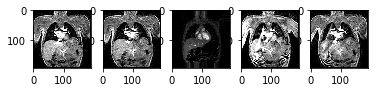

output result is below:


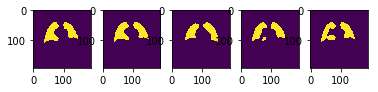

groundtruth result is below:


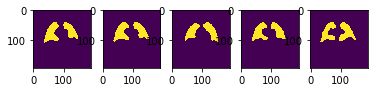

In [42]:
## testing train result
lungDataLoader = DataLoader(lung424, shuffle=True, batch_size=5)

dataiter = iter(lungDataLoader)

img, target = dataiter.next()

# print(img[i].cpu().numpy().dtype)

print(img.size(), target.size())

unet = torch.load('./unet_crosseEntrophy.pkl')

out = unet(Variable(img.cuda()))
print(out.size())

print('input result is below:')
for i in range(5):
    position = 150 + i + 1
    plt.subplot(position)
    plt.imshow(np.transpose(img[i].cpu().numpy(), (1,2,0)))
plt.show()

print('output result is below:')
for i in range(5):
    position = 150 + i + 1
    plt.subplot(position)
    _, predicted_out = torch.max(out[i],0)
#     print('predicted output size is {}'.format(predicted_out.size()))
#     print(np.unique(np.squeeze(predicted_out.data.cpu().numpy(), axis=0)))
    plt.imshow(np.squeeze(predicted_out.data.cpu().numpy(), axis=0))
plt.show()

print('groundtruth result is below:')
for i in range(5):
    position = 150 + i + 1
    plt.subplot(position)
    plt.imshow(np.transpose(np.squeeze(target[i].cpu().numpy(), axis=0), (0,1)))
plt.show()

In [4]:
## loading whole net model
#1. load both network structure and parameter
unet = torch.load('./unet.pkl')
print('loading unet whole model sucessfully !!!')

#2. load only the network parameter
unet.load_state_dict(torch.load('./unet_para.pkl'))
print('loading unet parameters sucessfully !!!')

loading unet whole model sucessfully !!!
loading unet parameters sucessfully !!!


(192, 192, 3) (192, 192, 3)


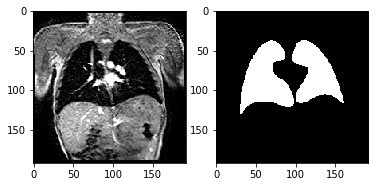

In [51]:
#show images
image, target = lung424.getRandItem()
print(image.shape, target.shape)

plt.figure(1)
plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(target*255)
plt.show()

In [26]:
## checkout network paremeters
# print(unet)  
  
# for param in unet.parameters():  
#     print('para type is {} and size is {}'.format(type(param.data), param.size()))
#     print('para list is {}'.format(list(param.data)))

## print out parameter keys
# print(unet.state_dict().keys())  

  
# for key in unet.state_dict():#模型参数  
#     print(key, 'corresponds to', list(unet.state_dict()[key]))

for m in unet.modules():
    print(m.__class__)

<class '__main__.UNET'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.upsampling.UpsamplingBilinear2d'>


In [29]:
def grey2rgb(img):
    w, h = img.shape
    out = np.empty([3,w,h], dtype=np.float32)
    for i in range(3):
        out[i,:,:] = img
    return out